# Comparative Analysis of Machine Learning Algorithms for Detecting Fake Economic News

Link to the Scraped Dataset - https://mylambton-my.sharepoint.com/:x:/g/personal/c0871416_mylambton_ca/EWh7MyN1VzhLlvnFptL90pYB7Si7O6RmSKWXA4dSDwXwyw?e=AULP95

# Table of contents

1. [Importing Libraries](#Libraries) 
2. [Scraping the data from website](#scraping)
3. [Data Loading and Wrangling](#loading)
4. [Visualization](#visualization)
5. [Missing Values and Duplicate Handling](#missing)
6. [Exploring the uniqe values in Target column](#explore)
7.[Test pre-processing](#preprocess)
8.[Training and testing ](#tnt)
9.[Model Training, Evaluation and Prediction](#modeling)
10.[Linear Support Vector Classification](#linearSVC)
11.[Logistic Regression](#logi)
12.[XGBoost](#XGBoost)
13.[Random Forest Classifier](#Random)
14.[SVM](#SVM)
15.[Comparison plot](#compare)

In [ ]:
 # ! pip install beautifulsoup4

In [ ]:
# ! pip install requests

In [ ]:
# ! pip install urllib

# Importing Libraries <a name='Libraries'></a>

In [101]:
from bs4 import BeautifulSoup
import urllib.request,sys,time
import requests

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Scraping data from a website - politifact <a name='scraping'></a>

In [ ]:
#created empty lists
authors=[]
dates=[]
statements=[]
source=[]
all_info=[]
targets=[]

In [ ]:
# number of pages to scrape
pagesToGet = 500

In [ ]:
upperframe=[]
for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url ='https://www.politifact.com/factchecks/list/?page='+str(page)+'&category=economy'
    page=requests.get(url) 
    soup=BeautifulSoup(page.text,'html.parser')
    
    # getting locations
    statement_footer=soup.find_all('footer', attrs={'class':'m-statement__footer'}) # location of author
    statement_qote = soup.find_all('div', attrs={'class':'m-statement__quote'}) # location of the statement
    statement_source= soup.find_all('div',attrs={'class':'m-statement__meta'}) # location of the source
    statement_info= soup.find_all('div',attrs={'class':'m-statement__quote'}) # location of the info
    target = soup.find_all('div', attrs={'class':'m-statement__meter'}) # location of the target (score card)
    
    #looping through footer to get the author's name and date of the post
    for i in statement_footer:
        link1 = i.text.strip()
        name_and_date = link1.split()
        first_name= name_and_date[1]
        last_name=name_and_date[2]
        full_name=first_name+' '+last_name
        month= name_and_date[-3]
        day = name_and_date[-2]
        year = name_and_date[-1]
        date= month+' '+day+' '+year
        dates.append(date)
        authors.append(full_name)
    
    #looping through the statement_quote to get the headline of the news
    for i in statement_qote:
        link2=i.find_all('a')
        statement_text=link2[0].text.strip()
        statements.append(statement_text)
        
    #looping through source to get from where  the news is collected
    for i in statement_source:
        link3 = i.find_all('a')
        source_text=link3[0].text.strip()
        source.append(source_text)
        
    #looping through the info to get the content of each and every new article

    for i in statement_info:
        link4 = "https://www.politifact.com"+i.find('a').get('href')
        link4_page=requests.get(link4)
        soup2=BeautifulSoup(link4_page.text,'html.parser')
        article_text=soup2.find('article',attrs={'class':'m-textblock'})
        if article_text is not None:
            p_element=article_text.find_all('p')
            info=[]
            for p in p_element:
                text_info=p.text.strip()
                info.append(text_info)
            all_info.append(info)
        else:
            all_info.append([])        #adds empty list if the artcile text is none
        

        
    
    
    
    #looping through the target to get the status of the news i.e either true/false
    for i in target:
        link6 = i.find('div', attrs={'class':'c-image'}).find('img').get('alt')
        targets.append(link6)


    

In [ ]:
# creating dataframe
data=pd.DataFrame(columns=['Author','Statement','Source','Text','Date','Target'])
data['Author']= authors
data['Statement']= statements
data['Source']= source
data['Text']= all_info
data['Date']= dates
data['Target']= targets

In [ ]:
data

In [ ]:
# storing this data to a csv file
data.to_csv('Political fact checker.csv')

# Data Loading and Wrangling <a name='loading'></a>

In [3]:
df=pd.read_csv('Political fact checker.csv')

In [4]:
df.head()

,Unnamed: 0,Author,Statement,Source,Text,Date,Target
0,0,D.L. Davis,"""Wisconsin has seen over 63 billion dollars of...",Joan Ballweg,"['Gov. Tony Evers, a Democrat, has clashed for...","March 14, 2023",mostly-true
1,1,Matthew Crowley,“We used to rank No. 1 in the world in researc...,Joe Biden,['President Joe Biden spent the week before hi...,"February 13, 2023",barely-true
2,2,Louis Jacobson,“We created more new jobs in two years than an...,Joe Biden,['President Joe Biden has regularly touted how...,"February 7, 2023",half-true
3,3,Vanessa Swales,"""In 2010, (Wisconsin Republicans) inherited a ...",Devin LeMahieu,"['With Gov. Tony Evers, a Democrat, poised to ...","February 3, 2023",mostly-true
4,4,Louis Jacobson,"“Two years ago this week, 18 million people we...",Joe Biden,['President Joe Biden recently touted his admi...,"January 27, 2023",half-true


In [5]:
df['Target'].value_counts()

half-true      428
mostly-true    401
false          323
true           294
barely-true    289
pants-fire      81
full-flop        6
half-flip        5
Name: Target, dtype: int64

### Replacing target values by 0 (true) and 1 (false)

In [6]:
df['Target']=df['Target'].replace(['mostly-true','true'],0)

In [7]:
df['Target']=df['Target'].replace(['half-true','false','barely-true','pants-fire','half-flip','full-flop'],1)

In [8]:
df.head()

,Unnamed: 0,Author,Statement,Source,Text,Date,Target
0,0,D.L. Davis,"""Wisconsin has seen over 63 billion dollars of...",Joan Ballweg,"['Gov. Tony Evers, a Democrat, has clashed for...","March 14, 2023",0
1,1,Matthew Crowley,“We used to rank No. 1 in the world in researc...,Joe Biden,['President Joe Biden spent the week before hi...,"February 13, 2023",1
2,2,Louis Jacobson,“We created more new jobs in two years than an...,Joe Biden,['President Joe Biden has regularly touted how...,"February 7, 2023",1
3,3,Vanessa Swales,"""In 2010, (Wisconsin Republicans) inherited a ...",Devin LeMahieu,"['With Gov. Tony Evers, a Democrat, poised to ...","February 3, 2023",0
4,4,Louis Jacobson,"“Two years ago this week, 18 million people we...",Joe Biden,['President Joe Biden recently touted his admi...,"January 27, 2023",1


In [179]:
df.shape

(1816, 2)

In [9]:
counts=df['Author'].value_counts()

In [10]:
# Create a list of sources that occur only once 
to_replace = counts[counts <= 5].index.tolist()     # choosing 10 as below that most are false statements

# Replace the names of sources that occur only once with "Other"
df['Author'] = df['Author'].apply(lambda x: 'Other' if x in to_replace else x)

In [11]:
df['Author'].value_counts()

Louis Jacobson    397
Other             260
C. Eugene         129
W. Gardner         78
Tom Kertscher      63
                 ... 
Peter Krouse        6
Janie Har           6
Ian K.              6
Nancy Madsen        6
Wes Hester          6
Name: Author, Length: 61, dtype: int64

# Data Visualization   <a name='visualization'></a>

<Figure size 2500x600 with 0 Axes>

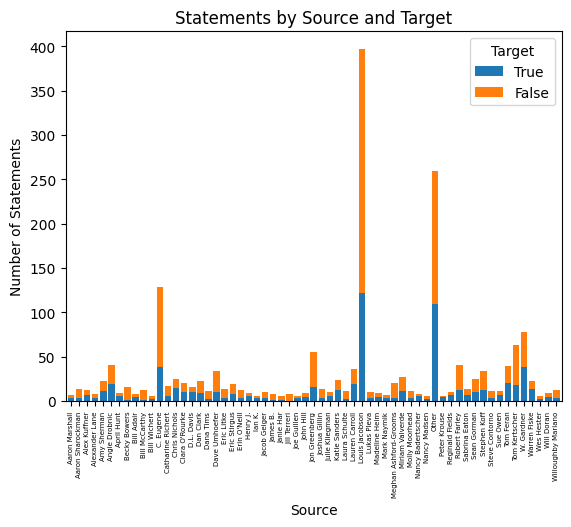

In [12]:
# Group the data by Source and Target, and count the number of statements
grouped = df.groupby(['Author', 'Target']).count()['Statement'].reset_index()

# Pivot the data to create a matrix with the number of statements for each source and target
pivoted = grouped.pivot(index='Author', columns='Target', values='Statement')

# Set the figure size and adjust the width of the plot and the x-axis, and increase the dpi
plt.figure(figsize=(25, 6), dpi=100)
pivoted.plot(kind='bar', stacked=True, width=0.8)
plt.xlabel('Source')
plt.ylabel('Number of Statements')
plt.title('Statements by Source and Target')
plt.legend(labels=['True', 'False'], title='Target', loc='upper right')

# Reduce the size of the x-tick labels
plt.xticks(fontsize=5)

plt.show()


In [13]:
#finding the headings of the column
for columns in df.columns:
    print(columns)

Unnamed: 0
Author
Statement
Source
Text
Date
Target


In [14]:
# dropping unwanted columns
df=df.drop(['Unnamed: 0','Source','Date','Author','Statement'], axis=1)

In [15]:
df.head()

,Text,Target
0,"['Gov. Tony Evers, a Democrat, has clashed for...",0
1,['President Joe Biden spent the week before hi...,1
2,['President Joe Biden has regularly touted how...,1
3,"['With Gov. Tony Evers, a Democrat, poised to ...",0
4,['President Joe Biden recently touted his admi...,1


# Missing value and duplication handling <a name='missing'></a>

#### checking for any nulls

In [17]:
df.isnull().sum()

Text      0
Target    0
dtype: int64

#### checking for duplicates and dropping them

In [18]:
df.duplicated().sum()

11

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
df.shape

(1816, 2)

#### Shuffling the data to prevent model from getting biased

In [21]:
df=df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

# Exploring the unique values in Target column <a name='explore'></a>

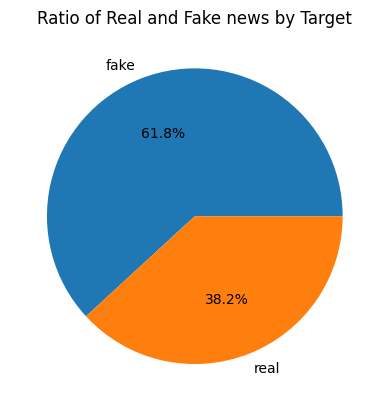

In [22]:
# Count the number of statements for each target
counts = df['Target'].value_counts()

# Create a pie chart
plt.pie(counts.values, labels=['fake', 'real'], autopct='%1.1f%%')
plt.title('Ratio of Real and Fake news by Target')

# Show the pie chart
plt.show()
# 0 = Real News
# 1 = Fake News

In [23]:
# ! pip install wordcloud

# Text pre-processing <a name= 'preprocess'></a>

In [24]:
len(df['Text'][0])

4411

### Removing all the stopwords, punctuations and any irrelevant spaces from the text

In [25]:
def preprocess_text(text_data):
    preprocessed_text = []
      
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)    #removes all non-word and non-space characters
        # converts the string into lower case, splits it to tokenize, removes stopwords and later on joins it
        preprocessed_text.append(' '.join(token.lower()            
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))
  
    return preprocessed_text
        

In [26]:
preprocessed_review = preprocess_text(df['Text'].astype(str).values)
df['Text'] = preprocessed_review

100%|██████████████████████████████████████████████████████████████████████████████| 1816/1816 [06:01<00:00,  5.03it/s]


In [27]:
len(df['Text'][0])

3256

### Bag of words 

####  ploting bargraph of the top 20 most frequent words.

In [28]:
def get_top_n_words (corpus,n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [29]:
common_words = get_top_n_words(df['Text'],20)

<AxesSubplot: title={'center': 'Bar Chart of top words frequency'}, xlabel='Top Words', ylabel='Count'>

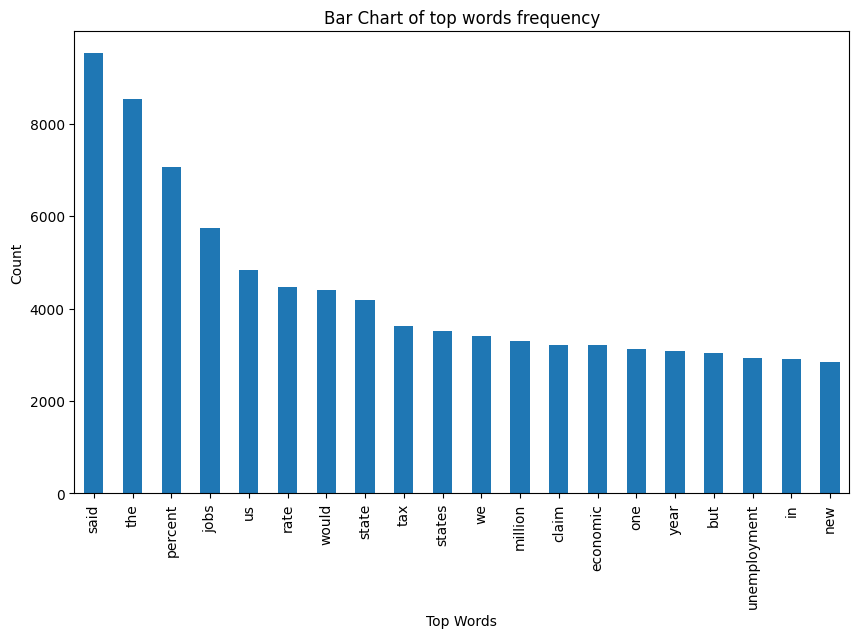

In [30]:
df1= pd.DataFrame(common_words,columns=['Review','Count'])
df1.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(kind='bar', figsize=(10,6),xlabel="Top Words",ylabel="Count", title='Bar Chart of top words frequency')

##  Training and testing  <a name='tnt'></a>

In [60]:
# Split data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(df['Text'], df['Target'], test_size=0.3)

#### Converting training data into vectors

In [61]:
# Initialize a TfidfVectorizer object
vectorization = TfidfVectorizer()

# Transform the training and testing data into feature vectors
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

#  Model Training, Evaluation and Prediction <a name ='modeling'></a>

##  (a) Linear Support Vector Classification  <a name='linearSVC'></a>

#### Tunning hyperparameters - finding optimum value for c for regularization

In [62]:
# Define the range of values to test for C
C_range = [0.001, 0.01, 0.1, 1, 10, 100]

# Define the parameters to search over
param_grid = {'C': C_range}

# Create a GridSearchCV object
grid = GridSearchCV(LinearSVC(penalty='l2'), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid.fit(x_train, y_train)

# Print the best value of C and the corresponding test accuracy
print("Best C:", grid.best_params_['C'])
print("Test Accuracy:", grid.best_score_)


Best C: 10
Test Accuracy: 0.707308939323761


#### To avoid overfitting we are using L2 regularization with  regularization strength c as 10

In [63]:
# Initialize a LinearSVC object with L2 regularization
model_SVC = LinearSVC(penalty='l2', C=10)
# Train the model on the training data
model_SVC.fit(x_train, y_train)

LinearSVC(C=10)

Accuracy: 74.86 %


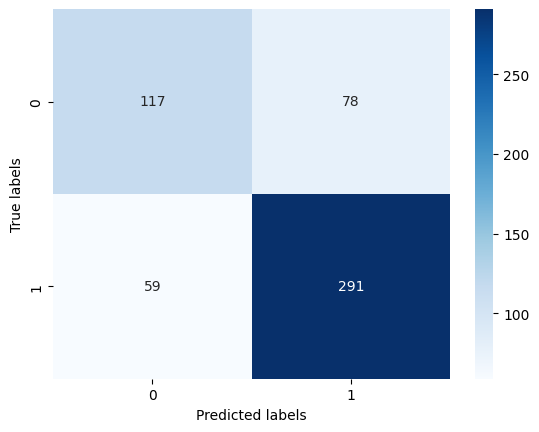

Classification Report:
 {'0': {'precision': 0.6647727272727273, 'recall': 0.6, 'f1-score': 0.6307277628032345, 'support': 195}, '1': {'precision': 0.7886178861788617, 'recall': 0.8314285714285714, 'f1-score': 0.8094575799721836, 'support': 350}, 'accuracy': 0.7486238532110092, 'macro avg': {'precision': 0.7266953067257945, 'recall': 0.7157142857142857, 'f1-score': 0.720092671387709, 'support': 545}, 'weighted avg': {'precision': 0.7443063155610705, 'recall': 0.7486238532110092, 'f1-score': 0.7455083793337522, 'support': 545}}


In [122]:
# Test the model on the testing data
y_test_pred_SVC = model_SVC.predict(x_test)
Accuracy_SVC = round((accuracy_score(y_test, y_test_pred_SVC))*100,2)
print('Accuracy:', Accuracy_SVC,"%")

confusion = confusion_matrix(y_test, y_test_pred_SVC)


sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

report_SVC= classification_report(y_test, y_test_pred_SVC, output_dict=True , zero_division=0)

print('Classification Report:\n', report_SVC)

## (b) Logistic Regression <a name='logi'></a>

In [66]:
# Define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# Initialize a LogisticRegression object
model_Logistic = LogisticRegression()

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(model_Logistic, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)

C:\Users\aanch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\aanch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aanch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aanch\AppData\Local\Programs\Pyth

Best hyperparameters found:
{'C': 10, 'penalty': 'l2'}


#### To avoid overfitting we are using L2 regularization with  regularization strength c as 10

In [67]:
# Initialize a LogisticRegression object with L2 regularization
model_Logistic = LogisticRegression(penalty='l2', C=10)
# Train the model on the training data
model_Logistic.fit(x_train, y_train)

LogisticRegression(C=10)

Accuracy: 73.39 %


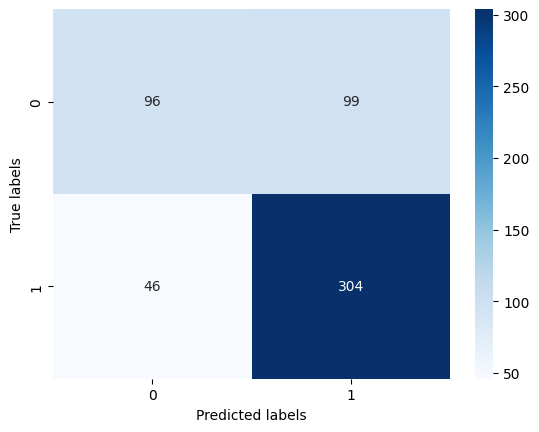

Classification Report:
 {'0': {'precision': 0.676056338028169, 'recall': 0.49230769230769234, 'f1-score': 0.56973293768546, 'support': 195}, '1': {'precision': 0.7543424317617866, 'recall': 0.8685714285714285, 'f1-score': 0.8074369189907038, 'support': 350}, 'accuracy': 0.7339449541284404, 'macro avg': {'precision': 0.7151993848949778, 'recall': 0.6804395604395604, 'f1-score': 0.6885849283380818, 'support': 545}, 'weighted avg': {'precision': 0.726331811068107, 'recall': 0.7339449541284404, 'f1-score': 0.7223868706337817, 'support': 545}}


In [123]:
# Test the model on the testing data
y_test_pred1 = model_Logistic.predict(x_test)

Accuracy_Logi = round((accuracy_score(y_test, y_test_pred1))*100,2)
print('Accuracy:', Accuracy_Logi,"%")

confusion = confusion_matrix(y_test, y_test_pred1)


sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

report_Logi = classification_report(y_test, y_test_pred1, output_dict=True , zero_division=0)
print('Classification Report:\n', report_Logi)

## (c) XGBoost  <a name='XGBoost'></a>

In [ ]:
# !pip install xgboost

#### Tunning Hyperparameters

In [70]:
# Define the range of values to test for learning_rate, max_depth, and n_estimators
learning_rate_range = [0.01, 0.1, 0.5, 1]


# Define the parameters to search over
param_grid = {
    'learning_rate': learning_rate_range,

}

# Create a GridSearchCV object
grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid.fit(x_train, y_train)

# Print the best values of learning_rate, max_depth, n_estimators, and the corresponding test accuracy
print("Best learning rate:", grid.best_params_['learning_rate'])

print("Test Accuracy:", grid.best_score_)


Best learning rate: 0.1
Test Accuracy: 0.9040080284082137


Accuracy: 90.83 %


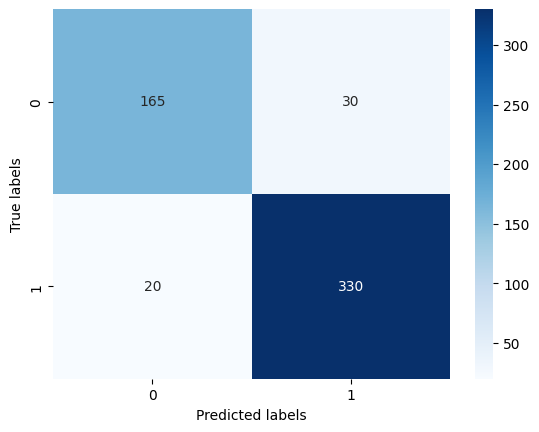

Classification Report:
 {'0': {'precision': 0.8918918918918919, 'recall': 0.8461538461538461, 'f1-score': 0.868421052631579, 'support': 195}, '1': {'precision': 0.9166666666666666, 'recall': 0.9428571428571428, 'f1-score': 0.9295774647887323, 'support': 350}, 'accuracy': 0.908256880733945, 'macro avg': {'precision': 0.9042792792792793, 'recall': 0.8945054945054944, 'f1-score': 0.8989992587101556, 'support': 545}, 'weighted avg': {'precision': 0.9078022977105545, 'recall': 0.908256880733945, 'f1-score': 0.907695812732503, 'support': 545}}


In [124]:
# Initialize an XGBoost classifier with L1 and L2 regularization
model_XGBoost = xgb.XGBClassifier(reg_lambda=0.1, alpha=0.5)

# Train the model on the training data
model_XGBoost.fit(x_train, y_train)


# Test the model on the testing data
y_test_xgboost = model_XGBoost.predict(x_test)


Accuracy_xgboost = round((accuracy_score(y_test, y_test_xgboost))*100,2)
print('Accuracy:', Accuracy_xgboost,"%")

confusion = confusion_matrix(y_test, y_test_xgboost)


sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

report_XGBoost = classification_report(y_test, y_test_xgboost, output_dict=True , zero_division=0)
print('Classification Report:\n',report_XGBoost )



## (d) Random Forest Classifier <a name='Random'></a>

In [75]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=5, min_samples_leaf=1)

#### Tune hyperparameters 

In [74]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [76]:
# Train the model
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=50)

Accuracy: 73.03 %


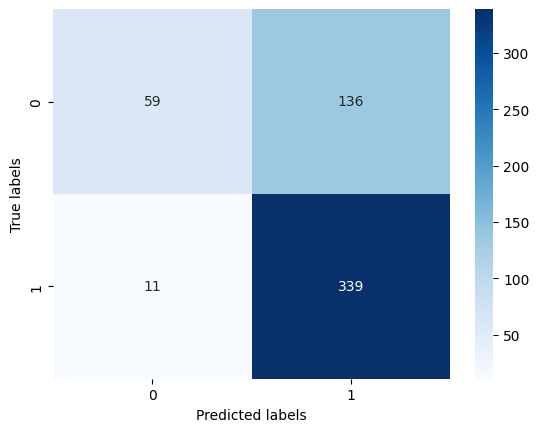

Classification Report:
 {'0': {'precision': 0.8428571428571429, 'recall': 0.30256410256410254, 'f1-score': 0.44528301886792454, 'support': 195}, '1': {'precision': 0.7136842105263158, 'recall': 0.9685714285714285, 'f1-score': 0.8218181818181819, 'support': 350}, 'accuracy': 0.7302752293577982, 'macro avg': {'precision': 0.7782706766917293, 'recall': 0.6355677655677655, 'f1-score': 0.6335506003430532, 'support': 545}, 'weighted avg': {'precision': 0.759902048699731, 'recall': 0.7302752293577982, 'f1-score': 0.6870945914047871, 'support': 545}}


In [125]:
y_pred_rf = rfc.predict(x_test)

Accuracy_rf = round((accuracy_score(y_test, y_pred_rf))*100,2)
print('Accuracy:', Accuracy_rf,"%")

confusion = confusion_matrix(y_test, y_pred_rf)


sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

report_rf= classification_report(y_test, y_pred_rf, output_dict=True , zero_division=0)
print('Classification Report:\n', report_rf)

## SVM <a name='SVM'></a>

In [81]:
# Create SVM model
model = SVC(kernel='linear')

In [82]:
# Train SVM model on training data
model.fit(x_train, y_train)

SVC(kernel='linear')

In [83]:
# Make predictions on testing data
predictions_SVM = model.predict(x_test)

Accuracy: 72.66 %


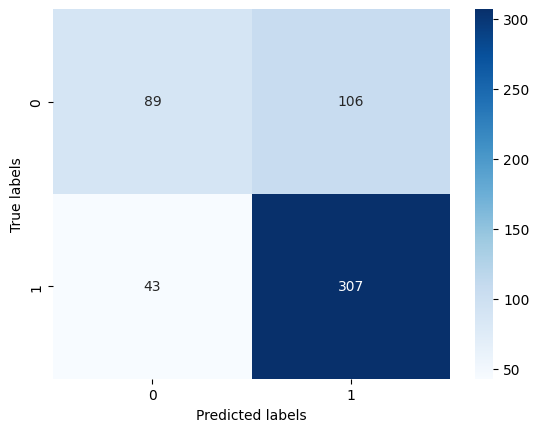

Classification Report:
 {'0': {'precision': 0.6742424242424242, 'recall': 0.4564102564102564, 'f1-score': 0.5443425076452599, 'support': 195}, '1': {'precision': 0.7433414043583535, 'recall': 0.8771428571428571, 'f1-score': 0.8047182175622541, 'support': 350}, 'accuracy': 0.726605504587156, 'macro avg': {'precision': 0.7087919143003889, 'recall': 0.6667765567765568, 'f1-score': 0.6745303626037571, 'support': 545}, 'weighted avg': {'precision': 0.7186179160599935, 'recall': 0.726605504587156, 'f1-score': 0.7115562663075499, 'support': 545}}


In [126]:
# Calculate accuracy and confusion matrix

Accuracy_SVM = round((accuracy_score(y_test, predictions_SVM))*100,2)
print('Accuracy:', Accuracy_SVM,"%")

confusion = confusion_matrix(y_test, predictions_SVM)


sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

report_SVM = classification_report(y_test, predictions_SVM, output_dict=True , zero_division=0)
print('Classification Report:\n',report_SVM )

# Comparison plot <a name='compare'></a>

In [177]:
# Get the recall, precision, and accuracy values for each model
recalls = [report_SVC['1']['recall'], report_Logi['1']['recall'], report_XGBoost['1']['recall'], report_rf['1']['recall'], report_SVM['1']['recall']]
precisions = [report_SVC['1']['precision'], report_Logi['1']['precision'], report_XGBoost['1']['precision'], report_rf['1']['precision'], report_SVM['1']['precision']]
f1_scores = [report_SVC['1']['f1-score'], report_Logi['1']['f1-score'], report_XGBoost['1']['f1-score'], report_rf['1']['f1-score'], report_SVM['1']['f1-score']]
accuracies = [Accuracy_SVC, Accuracy_Logi, Accuracy_xgboost, Accuracy_rf, Accuracy_SVM]


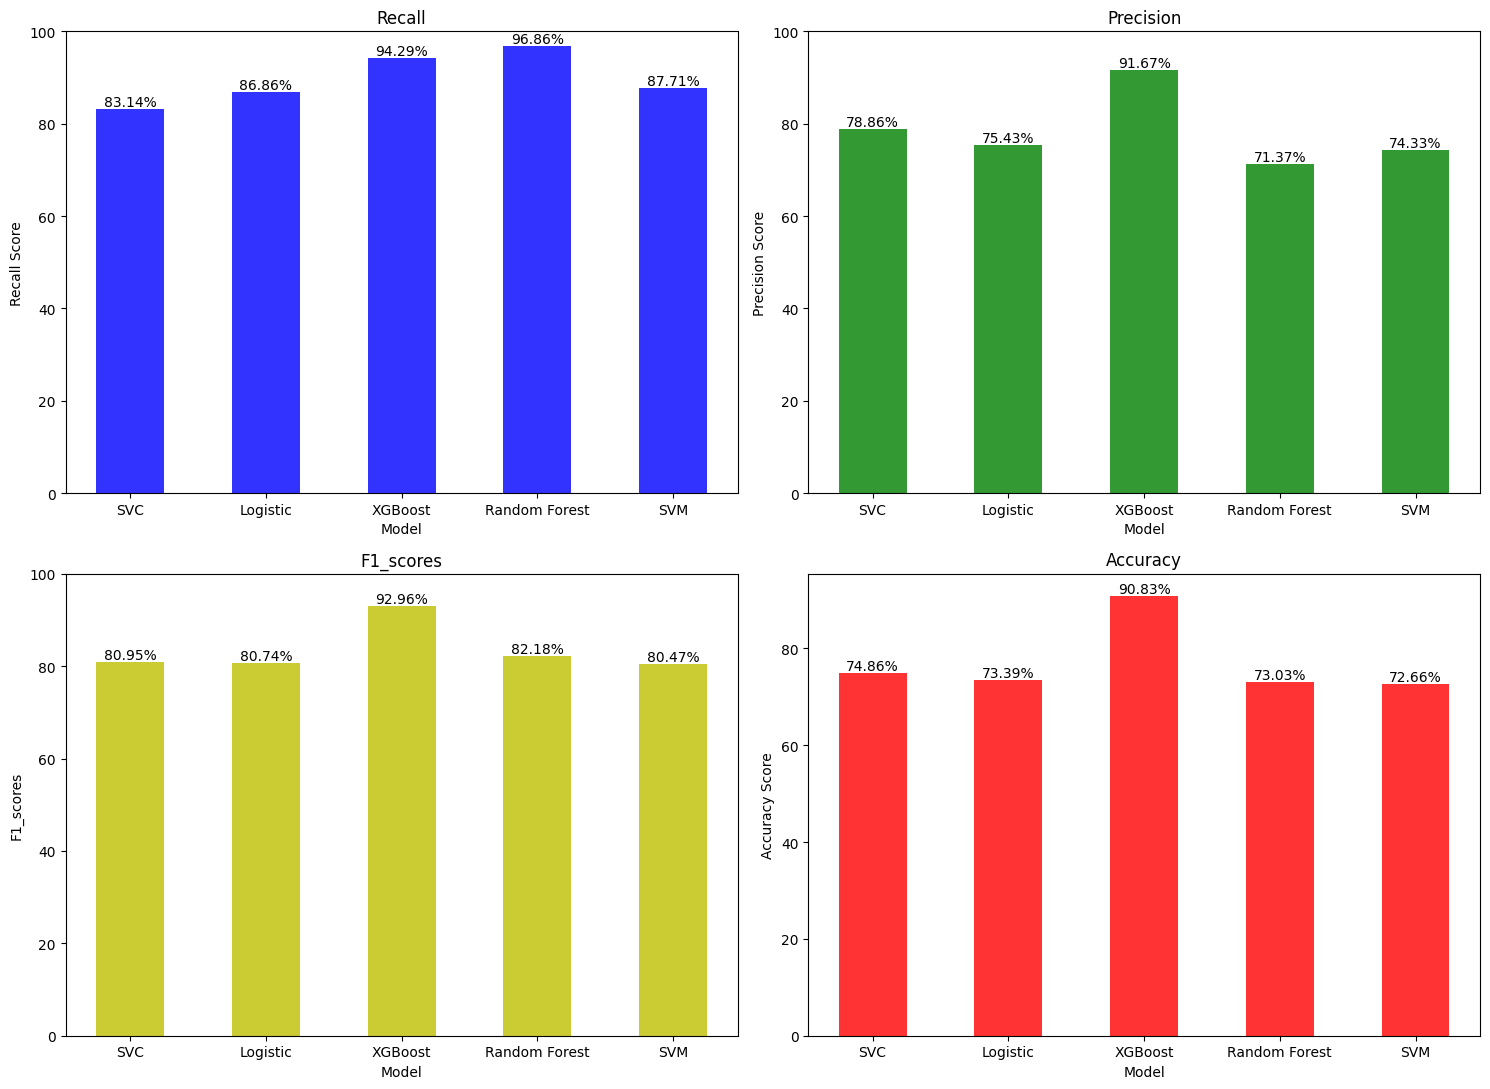

In [178]:
recalls = [x * 100 for x in recalls]
precisions = [x * 100 for x in precisions]
f1_scores = [x * 100 for x in f1_scores]

# Set up the bar graphs
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
bar_width = 0.5
opacity = 0.8
index = np.arange(len(models))

# Plot the recall bar graph
rec_bar = ax[0,0].bar(index, recalls, bar_width,
                 alpha=opacity,
                 color='b')
ax[0,0].set_xlabel('Model')
ax[0,0].set_ylabel('Recall Score')
ax[0,0].set_title('Recall')
ax[0,0].set_xticks(index)
ax[0,0].set_xticklabels(models)
ax[0,0].set_ylim([0, 100]) # Set the y-axis range

# Add text labels on top of each bar in recall plot
for i, v in enumerate(recalls):
    ax[0,0].text(i, v, str(round(v,2)) + '%', ha='center', va='bottom')

# Plot the precision bar graph
prec_bar = ax[0,1].bar(index, precisions, bar_width,
                 alpha=opacity,
                 color='g')
ax[0,1].set_xlabel('Model')
ax[0,1].set_ylabel('Precision Score')
ax[0,1].set_title('Precision')
ax[0,1].set_xticks(index)
ax[0,1].set_xticklabels(models)
ax[0,1].set_ylim([0, 100]) # Set the y-axis range

# Add text labels on top of each bar in precision plot
for i, v in enumerate(precisions):
    ax[0,1].text(i, v, str(round(v,2)) + '%', ha='center', va='bottom')

# Plot the f1-score bar graph
f1_bar = ax[1,0].bar(index, f1_scores, bar_width,
                 alpha=opacity,
                 color='y')
ax[1,0].set_xlabel('Model')
ax[1,0].set_ylabel('F1_scores')
ax[1,0].set_title('F1_scores')
ax[1,0].set_xticks(index)
ax[1,0].set_xticklabels(models)
ax[1,0].set_ylim([0, 100]) # Set the y-axis range

# Add text labels on top of each bar in f1-score plot
for i, v in enumerate(f1_scores):
    ax[1,0].text(i, v, str(round(v,2)) + '%', ha='center', va='bottom')

    
# Plot the accuracy bar graph
acc_bar = ax[1,1].bar(index, accuracies, bar_width,
                 alpha=opacity,
                 color='r')
ax[1,1].set_xlabel('Model')
ax[1,1].set_ylabel('Accuracy Score')
ax[1,1].set_title('Accuracy')
ax[1,1].set_xticks(index)
ax[1,1].set_xticklabels(models)

# Add text labels on top of each bar in accuracy plot
for i, v in enumerate(accuracies):
    ax[1,1].text(i, v, str(round(v,2)) + '%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
